In [1]:
import shutil, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset
import detectron2.utils.comm as comm
from detectron2.engine import launch



reprocess_results=False
# dataset_name = "reserves_fold1"
dataset_name = "test"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_fold1/model_final.pth",
#                      "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
./output


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

# Prediction


In [4]:

#%%script false --no-raise-error
#os.environ["NCCL_DEBUG"] = "INFO"
#from torch.nn.parallel import DistributedDataParallel
from detectron2.modeling import build_model
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
#from plain_train_net import EvaluateClass
from detectron2.evaluation import inference_on_dataset, COCOEvaluator

def predict_func(cfg,dataset_name):

    model = build_model(cfg)  # returns a torch.nn.Module
    # distributed = comm.get_world_size() > 1
    # if distributed:
    #     model = DistributedDataParallel(
    #         model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
    #     )
    myloader = build_detection_test_loader(cfg,dataset_name)    
    myeval = COCOEvaluator(dataset_name,tasks={'bbox','segm'},output_dir ="output_"+ dataset_name) #produces _coco_format.json when initialized


    for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
        #build model
        model_weights_path = "output_valid_"+ mdl +"/model_final.pth"
        DetectionCheckpointer(model).load(model_weights_path);  # load a file, usually from cfg.MODEL.WEIGHTS
        model.eval(); #set model in evaluation mode
        myeval.reset()
        output_dir = "output_"+ dataset_name + "/"+mdl
        myeval._output_dir = output_dir
        results_i = inference_on_dataset(model, myloader, myeval) #produces coco_instance_results.json when myeval.evaluate is called
    
    return

predict_func(cfg,dataset_name)
# launch(
#     predict_func,
#     6, # of gpus
#     num_machines=1,
#     machine_rank=0,
#     dist_url="auto",
#     args=(cfg,dataset_name,), #args to predict_func
# )

Using previously cached COCO format annotations at 'output_ext_test/ext_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


# Ensembling 

In [5]:
#%%script false --no-raise-error
from Ensembler import Ensembler
ens = Ensembler('output_'+dataset_name,dataset_name,["fold1", "fold2", "fold3", "fold4","fold5"],.2)
ens.mean_score_nms()
ens.save_coco_instances()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Successfully loaded output_ext_test/fold1/coco_instances_results.json into memory. 31392 instance detected.

Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Successfully loaded output_ext_test/fold2/coco_instances_results.json into memory. 29391 instance detected.

Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Successfully loaded output_ext_test/fold3/coco_instances_results.json into memory. 32281 instance detected.

Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Successfully loaded output_ext_test/fold4/coco_instances_results.json into memory. 26330 instance detected.

Loading and preparing results...
DONE (t=0.31s)
creating index...
index created!
Successfully loaded output_ext_test/fold5/coco_instances_results.json into m

100%|██████████| 13813/13813 [01:58<00:00, 116.33it/s]


40425 resulting instances from NMS


# Evaluation

## Ensemble

Using previously cached COCO format annotations at 'output_test/test_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'test', 'precision': 0.6388400702987698, 'precision_ci': (0.6105330907245708, 0.6662144591819852), 'recall': 0.6900000000000001, 'recall_ci': (0.6613750455776731, 0.7172397291664632), 'f1': 0.6634352144529234, 'f1_ci': (0.6436035547117265, 0.6832668741941204), 'fpr': 0.04431137724550898, 'fpr_ci': (0.03544331230466729, 0.055271125668436026), 'iou': 0.2, 'probability': 0.5}


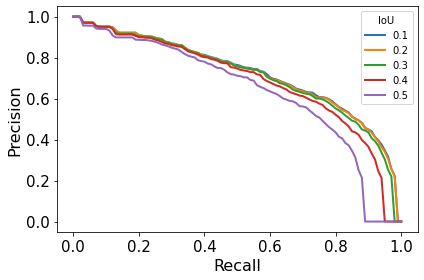

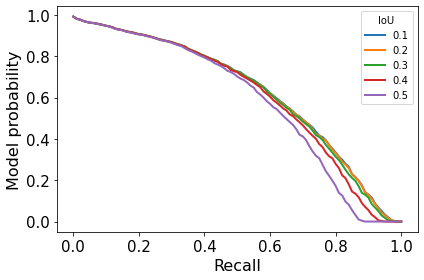

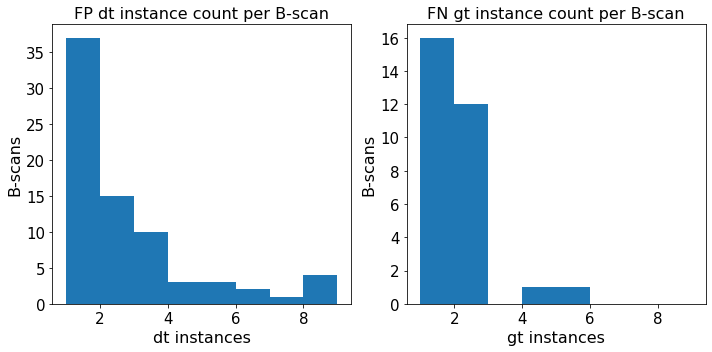

In [4]:
from plain_train_net import EvaluateClass,CreatePlotsRPD
import json
#evaluate ensemble
myeval = EvaluateClass(
    dataset_name, "output_"+ dataset_name,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()
%precision 3
print(myeval.summarize_scalars())
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json'),"w") as outfile:
    json.dump(obj=myeval.summarize_scalars(),fp=outfile)
num_images = myeval.num_images
myeval.plot_PRcurve()
plt.tight_layout()
myeval.plot_recall_vs_prob()
plt.tight_layout()

RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)
RPDplt.gt_dt_FP_FN_count();


## Individual Models

In [5]:
#evaluate individual models
import json
myeval.evalsuper=False
for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
    myeval.reset()
    output_dir = "output_"+ dataset_name + "/"+mdl
    myeval._output_dir = output_dir
    myeval.evaluate()
    print(myeval.summarize_scalars())
    with open(os.path.join(output_dir,'scalar_dict.json'),"w") as outfile:
        json.dump(obj=myeval.summarize_scalars(),fp=outfile)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'test', 'precision': 0.6124595469255664, 'precision_ci': (0.5850905041906551, 0.6391367091281999), 'recall': 0.72, 'recall_ci': (0.6920771570798393, 0.7463188978870552), 'f1': 0.6618900735919171, 'f1_ci': (0.6423593930717971, 0.6814207541120371), 'fpr': 0.046706586826347304, 'fpr_ci': (0.037584700763945544, 0.05790916197671044), 'iou': 0.2, 'probability': 0.5}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.17s).
Accumulating eva

In [6]:
import json, os
import pandas as pd
import numpy as np
from table_styles import styles
mydicts=[]

for mdl in ['fold1','fold2','fold3','fold4','fold5']:
    output_dir = "output_"+ dataset_name + "/"+mdl
    with open(os.path.join(output_dir,'scalar_dict.json')) as f:
        mydicts.append(json.load(f))
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json')) as f:
    mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
dfr = dfr.assign(fp = np.int32(dfr.fpr*num_images))
#dfr = dfr.assign(f1 = 2*(dfr.precision*dfr.recall)/(dfr.precision + dfr.recall))
dfr = dfr.assign(model = ['1','2','3','4','5','ensemble'])
# dfr = dfr[['model','fpr','fp','probability','dataset']]
dfr['precision_ci'] = dfr['precision_ci'].apply(lambda x: pd.Interval(np.round(x[0],3),np.round(x[1],3),closed='both'))
dfr['recall_ci'] = dfr['recall_ci'].apply(lambda x: pd.Interval(np.round(x[0],3),np.round(x[1],3),closed='both'))
dfr['f1_ci'] = dfr['f1_ci'].apply(lambda x: pd.Interval(np.round(x[0],3),np.round(x[1],3),closed='both'))
dfr['fpr_ci'] = dfr['fpr_ci'].apply(lambda x: pd.Interval(np.round(x[0],3),np.round(x[1],3),closed='both'))
dfr = dfr[['model','dataset','precision','precision_ci','recall','recall_ci','f1','f1_ci','fpr','fpr_ci','fp','iou','probability']]
pd.set_option('display.precision',3)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,model,dataset,precision,precision_ci,recall,recall_ci,f1,f1_ci,fpr,fpr_ci,fp,iou,probability
0,1,test,0.612,"[0.585, 0.639]",0.720,"[0.692, 0.746]",0.662,"[0.642, 0.681]",0.047,"[0.038, 0.058]",91,0.200,0.500
1,2,test,0.614,"[0.586, 0.641]",0.710,"[0.682, 0.737]",0.659,"[0.639, 0.678]",0.046,"[0.037, 0.057]",90,0.200,0.500
2,3,test,0.585,"[0.558, 0.611]",0.740,"[0.713, 0.766]",0.653,"[0.634, 0.673]",0.049,"[0.04, 0.061]",96,0.200,0.500
3,4,test,0.693,"[0.663, 0.721]",0.640,"[0.611, 0.668]",0.665,"[0.645, 0.686]",0.039,"[0.031, 0.049]",76,0.200,0.500
4,5,test,0.635,"[0.607, 0.663]",0.690,"[0.661, 0.717]",0.662,"[0.642, 0.681]",0.044,"[0.035, 0.055]",86,0.200,0.500
5,ensemble,test,0.639,"[0.611, 0.666]",0.690,"[0.661, 0.717]",0.663,"[0.644, 0.683]",0.044,"[0.035, 0.055]",86,0.200,0.500


# Visualize Output

In [27]:

from plain_train_net import OutputVis

dataset_name = 'ext_test'
pred_file = "output_"+ dataset_name + "/coco_instances_results.json"
out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+dataset_name+'_nonrpd.pdf')

# mdl = 'fold1'
# pred_file = os.path.join("output_"+ dataset_name,mdl,"coco_instances_results.json")
# out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+mdl+'.pdf')

# vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=False)
# ImgIds = RPDplt.dfimg.index[RPDplt.dfimg.dt_instances>0] #np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
# vis.output_to_pdf(ImgIds,out_file)

df = RPDplt.dfimg
vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=False)
ImgIds = RPDplt.dfimg[RPDplt.dfimg.dt_instances==0].sample(50).index.values
#ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:10].values
vis.output_to_pdf(ImgIds,out_file)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [28]:
from table_styles import styles
dfpts = RPDplt.dfpts.sort_values(by=['dt_instances'],ascending=False)
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join('output_'+ dataset_name + '/dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [34]:
dfimg = RPDplt.dfimg.sort_index()
html_str = dfimg.style.set_table_styles(styles).render()
html_file = open(os.path.join('output_'+ dataset_name + '/dfimg_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [36]:
dfpts.sum()

gt_instances          0.0
gt_pxs                0.0
gt_xpxs               0.0
dt_instances       6897.0
dt_pxs          1424332.0
dt_xpxs          232663.0
dtype: float64